In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderBookArrays as job

In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [5]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [6]:
stock = 'GOOG' # 'GOOG', 'INTC'

In [7]:
if stock == 'GOOG':
    ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)
elif stock == 'INTC':
    ckpt_path = '../checkpoints/pleasant-cherry-152_i6h5n74c/' # 0.5 y INTC, (full model)

In [8]:
ckpt_path

'../checkpoints/treasured-leaf-149_84yhvzjt/'

In [9]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=4, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [10]:
# scale down to single GPU, single sample inference
args.bsz = 1 #1, 10
args.num_devices = 1

batchnorm = args.batchnorm

In [11]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [12]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [13]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [14]:
price_levels = 20

In [15]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [16]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [17]:
# entire test set (after training data)

if stock == 'GOOG':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/GOOG/'
elif stock == 'INTC':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/INTC/'

msg_files = sorted(glob(str(data_dir) + '/*message*.npy'))
book_files = sorted(glob(str(data_dir) + '/*book*.npy'))

ds = LOBSTER_Dataset(
    msg_files,
    n_messages=n_messages + n_eval_messages,
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    seed=42,
    n_cache_files=100,
    randomize_offset=False,
    book_files=book_files,
    use_simple_book=True,
    book_transform=False,
    book_depth=500,
    return_raw_msgs=True,
)

In [18]:
data_dir

'/nfs/home/peern/LOBS5/data/test_set/GOOG/'

In [19]:
ds.book_files

['/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-14_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-15_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-16_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-19_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-20_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-21_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-22_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-23_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-27_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-28_34200000_57600000_orderbook_10_p

In [20]:
import chex
chex.clear_trace_counter()

In [123]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [126]:
i = 1234
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

side = 1
quantity = 100
rel_price = 0

rng, rng_ = jax.random.split(rng)

results = inference.generate_impact_rollout(
    side,
    quantity,
    rel_price,
    m_seq,
    b_seq_pv,
    msg_seq_raw,
    book_l2_init,
    seq_len,
    n_messages,
    n_gen_msgs,
    state,
    model,
    batchnorm,
    v.ENCODING,
    rng,
    n_vol_series,
    sim_book_levels,
    sim_queue_len,
    data_levels
)

[967000     68 966900    100 967100    104 966800    663 967200    100
 966700    763 967300    129 966600   1200 967400   2996 966500    586
 967500   2830 966400    864 967600    865 966300    671 967700   1162
 966200   1152 967800   1315 966100    514 967900    826 966000   1201
 968000    500 965900    950     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 966900
abs_price 966900
rel_price 0


In [142]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [177]:
n_samples = 30 # 500
side = 1  # buy
quantity = 100  # 100
# rel_price = 10
level = 1  # best ask

rng, rng_ = jax.random.split(rng)

inference.study_impact(
    side,
    quantity,
    level,
    n_samples,  # draw n random samples from dataset for evaluation
    ds,
    rng,
    seq_len,
    n_messages,
    n_gen_msgs,
    state,
    model,
    batchnorm,
    v.ENCODING
)

  0%|          | 0/30 [00:00<?, ?it/s]

Processing sample 39112...
[893000    883 892700    984 893100   2492 892600    412 893200   3158
 892500   1640 893300   2569 892400   1176 893400   2973 892300   1002
 893500   1092 892200   1172 893600    150 892100    947     -1      0
 892000   1251     -1      0 891900    900     -1      0 891800    350
     -1      0 891700    650     -1      0 891600    401     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 892800
abs_price 893000
rel_price 2


  3%|▎         | 1/30 [00:54<26:33, 54.96s/it]

Processing sample 18351...
[895500    800 895300    200 895600   2844 895100    768 895700   1902
 895000    205 895800   1116 894900    100 895900   1247 894800    600
 896000   1253 894700   1103 896100     50 894600    500     -1      0
 894500   1399     -1      0 894400    997     -1      0 894300    500
     -1      0 894200    304     -1      0 894100    356     -1      0
 894000    218     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 895400
abs_price 895500
rel_price 1


  7%|▋         | 2/30 [01:50<25:49, 55.35s/it]

Processing sample 8029...
[907900     70 907800    225 908100   1271 907600    270 908200   3593
 907500    579 908300   3017 907400    419 908400   1938 907300    400
 908500    872 907200    742 908600    750 907100   1373 908700    953
 907000    680 908800    844 906900    673     -1      0 906800    150
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 907800
abs_price 907900
rel_price 1


 10%|█         | 3/30 [02:57<27:21, 60.78s/it]

Processing sample 32272...
[878700   1300 878200   1086 878800   3812 878100    824 878900    850
 878000    382 879000   1150 877900    632 879100   1050 877800   1710
 879200   1418 877700   1100     -1      0 877600   2189     -1      0
 877500    593     -1      0 877400    635     -1      0 877300    558
     -1      0 877200    100     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 878400
abs_price 878700
rel_price 3


 13%|█▎        | 4/30 [03:52<25:13, 58.20s/it]

Processing sample 22380...
[885900   2576 885800    251 886000   2384 885700   1000 886100   1365
 885600   1185 886200    865 885500    738 886300   1143 885400   1177
 886400    973 885300    409 886500    743 885200    291 886600     50
 885100    300 886700    150 885000    500     -1      0 884900    599
     -1      0 884800    362     -1      0 884700    456     -1      0
 884600    449     -1      0 884500    306     -1      0 884400    100
     -1      0 884300     50     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 885800
abs_price 885900
rel_price 1


 17%|█▋        | 5/30 [04:48<23:57, 57.51s/it]

Processing sample 6383...
[922700   1149 922900     20 922800   2493 922500    487 922900   1658
 922400   1141 923000    590 922300    501 923100   1051 922200    652
 923200    980 922100    405 923300   1025 922000    651 923400    241
 921900    406     -1      0 921800    962     -1      0 921700    339
     -1      0 921600    657     -1      0 921500   1120     -1      0
 921400   1070     -1      0 921300    100     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 922800
abs_price 922700
rel_price -1


 20%|██        | 6/30 [05:57<24:35, 61.46s/it]

Processing sample 20812...
[903400     94 903400    190 903500   3643 903300    822 903600   1902
 903200    300 903700   1005 903100   1730 903800   1550 903000    470
 903900    615 902900    400 904000    400 902800    767 904100    320
 902700    368     -1      0 902600    850     -1      0 902500    474
     -1      0 902400    597     -1      0 902300   1120     -1      0
 902200    887     -1      0 902100    475     -1      0 902000   1002
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 903400
abs_price 903400
rel_price 0


 23%|██▎       | 7/30 [06:50<22:26, 58.55s/it]

Processing sample 23846...
[878700    551 878400    815 878800   2739 878300    494 878900   2044
 878200    928 879000   2307 878100    821 879100   2827 878000   1725
 879200   2053 877900    900 879300   1000 877800   1400 879400   1160
 877700    400 879500    600 877600   1650     -1      0 877400     50
     -1      0 877300     50     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 878500
abs_price 878700
rel_price 2


 27%|██▋       | 8/30 [07:45<21:08, 57.64s/it]

Processing sample 25217...
[880000   1907 879800    571 880100   1916 879700    300 880200   3278
 879600   1302 880300   3855 879500    924 880400   2199 879400    600
 880500   2493 879300   1400 880600   1553 879200   1600 880700    793
 879100   2100     -1      0 879000    800     -1      0 878900    550
     -1      0 878800    550     -1      0 878600    850     -1      0
 878500    100     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 879900
abs_price 880000
rel_price 1


 30%|███       | 9/30 [08:40<19:53, 56.85s/it]

Processing sample 38852...
[890600   2581 890700    100 890700   3920 890400    611 890800   3964
 890300   2779 890900   1091 890200   1547 891000    435 890100    585
 891100    859 890000   1411 891200    300 889900   1219     -1      0
 889800    810     -1      0 889700   1316     -1      0 889600   1050
     -1      0 889500    978     -1      0 889400    653     -1      0
 889300    457     -1      0 889200    443     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 890600
abs_price 890600
rel_price 0


 33%|███▎      | 10/30 [09:48<20:03, 60.19s/it]

Processing sample 15813...
[886600   1622 886400    300 886700   3547 886300    100 886800   1868
 886200    800 886900   1784 886100    973 887000   1000 886000   1500
 887100    717 885900    400 887200    300 885800    850     -1      0
 885700    604     -1      0 885600    622     -1      0 885500    479
     -1      0 885400    651     -1      0 885300    470     -1      0
 885200    703     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 886500
abs_price 886600
rel_price 1


 37%|███▋      | 11/30 [10:43<18:33, 58.59s/it]

Processing sample 29082...
[897300    100 897000    100 897400   1550 896900    160 897500   1857
 896800    300 897600   3267 896700    350 897700   1625 896600    750
 897800   2233 896500    850 897900    525 896400    500 898000    761
 896300    500 898100    500 896200    950     -1      0 896100    772
     -1      0 896000    150     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 897100
abs_price 897300
rel_price 2


 40%|████      | 12/30 [11:37<17:08, 57.14s/it]

Processing sample 6938...
[915300   1459 914900    417 915400   1103 914800   1296 915500   1352
 914700   1342 915600   1345 914600    746 915700   2436 914500    700
 915800   1406 914400    750     -1      0 914300    260     -1      0
 914200    846     -1      0 914100    214     -1      0 914000    973
     -1      0 913900    314     -1      0 913800    100     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 915100
abs_price 915300
rel_price 2


 43%|████▎     | 13/30 [12:49<17:29, 61.75s/it]

Processing sample 4882...
[951900    200 951800    222 952000   3339 951700    150 952100    916
 951600    581 952200    450 951500    869 952300    850 951400    444
 952400    500 951300    557 952500    400 951200    414     -1      0
 951100    152     -1      0 951000    600     -1      0 950900    800
     -1      0 950800    900     -1      0 950700    508     -1      0
 950600    457     -1      0 950500    256     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 951800
abs_price 951900
rel_price 1


 47%|████▋     | 14/30 [14:01<17:16, 64.81s/it]

Processing sample 18260...
[893000   2561 892700    266 893100   3988 892600    600 893200   1495
 892500   1856 893300   1300 892400   1284 893400    918 892300    867
 893500    597 892200    500     -1      0 892100    489     -1      0
 892000   1299     -1      0 891900   1200     -1      0 891800    450
     -1      0 891700   1300     -1      0 891600    306     -1      0
 891500    650     -1      0 891400    156     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 892800
abs_price 893000
rel_price 2


 50%|█████     | 15/30 [15:01<15:51, 63.44s/it]

Processing sample 6754...
[915000   3112 915000    302 915100   1645 914900    147 915200   1607
 914800   1420 915300   1007 914700   1345 915400    850 914600   1294
 915500   1327 914500    579 915600    400 914400   1075 915700    450
 914300    355     -1      0 914200   1200     -1      0 914100    815
     -1      0 914000    386     -1      0 913900   1546     -1      0
 913800    728     -1      0 913700   1274     -1      0 913600    715
     -1      0 913500    755     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 915000
abs_price 915000
rel_price 0


 53%|█████▎    | 16/30 [16:00<14:27, 61.98s/it]

Processing sample 25846...
[881000     42 881000     38 881100    660 880900    122 881200    788
 880800    244 881300    172 880500    718 881400    848 880400     78
 881500     22 880300    100 881600     50 880200    115 881700    100
 880100    143 881900    600 880000    100 882200    100 879900    100
 882400    100 879800    673 882700     22 879700    162 882900    132
 879600    100     -1      0 879300     50     -1      0 879100    200
     -1      0 879000    422     -1      0 878900    200     -1      0
 878800    178     -1      0 878700    464     -1      0 878600    300]
p_mid_old 881000
abs_price 881000
rel_price 0


 57%|█████▋    | 17/30 [16:56<13:03, 60.23s/it]

Processing sample 12591...
[908400   3102 907900    955 908500    400 907800    401 908600   1282
 907700    200 908700   2617 907600    200 908800    310 907500    400
     -1      0 907400    300     -1      0 907300    400     -1      0
 907200    700     -1      0 907100    940     -1      0 907000    680
     -1      0 906900    776     -1      0 906800    679     -1      0
 906700    300     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 908100
abs_price 908400
rel_price 3


 60%|██████    | 18/30 [17:55<11:59, 59.95s/it]

Processing sample 40279...
[875800    564 875900    293 875900   3988 875400    100 876000   2406
 875300   1108 876100   2723 875200   1301 876200    725 875100    521
 876300    650 875000   1301 876400    250 874900    842 876500    201
 874800    610     -1      0 874700   1486     -1      0 874600   1170
     -1      0 874500    943     -1      0 874400     50     -1      0
 874300    100     -1      0 874200    100     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 875800
abs_price 875800
rel_price 0


 63%|██████▎   | 19/30 [18:50<10:41, 58.34s/it]

Processing sample 40867...
[879000   1887 878900    116 879100   2462 878800    100 879200   1158
 878700    100 879300   1868 878600    247 879400    100 878500   1120
     -1      0 878400    882     -1      0 878300    669     -1      0
 878200   1369     -1      0 878100   1067     -1      0 878000    800
     -1      0 877900   1740     -1      0 877800   1885     -1      0
 877700    479     -1      0 877600    784     -1      0 877500    547
     -1      0 877400    743     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 878900
abs_price 879000
rel_price 1


 67%|██████▋   | 20/30 [19:54<10:00, 60.00s/it]

Processing sample 26369...
[884400   1028 884300    117 884500   1281 884200    300 884600   1174
 884100    355 884700    646 884000    833 884800    100 883900    872
 884900    740 883800   1468 885000    200 883700    898 885100    100
 883600   1192     -1      0 883500    800     -1      0 883400    990
     -1      0 883300    512     -1      0 883200    568     -1      0
 883100    702     -1      0 883000    769     -1      0 882900    212
     -1      0 882800    336     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 884300
abs_price 884400
rel_price 1


 70%|███████   | 21/30 [21:00<09:15, 61.76s/it]

Processing sample 8837...
[912400    200 912300    300 912500   1047 912200    200 912600   2633
 911900    458 912700   2568 911800   1105 912800   1897 911700    469
 912900   1050 911600    522 913000    750 911500   1100 913100    400
 911400    500     -1      0 911300    500     -1      0 911200    627
     -1      0 911100    900     -1      0 911000    700     -1      0
 910800    100     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 912300
abs_price 912400
rel_price 1


 73%|███████▎  | 22/30 [21:58<08:04, 60.60s/it]

Processing sample 23316...
[880000   2504 879600    300 880100   2476 879500    981 880200    750
 879400    367 880300   1526 879300   1966 880400   1065 879200    599
     -1      0 879100    607     -1      0 879000   1300     -1      0
 878900   1100     -1      0 878800   1000     -1      0 878700    465
     -1      0 878600    514     -1      0 878500    467     -1      0
 878400    473     -1      0 878300    100     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 879800
abs_price 880000
rel_price 2


 77%|███████▋  | 23/30 [22:51<06:50, 58.58s/it]

Processing sample 3970...
[951000    700 950600    436 951100    200 950500    431 951200   1528
 950400    600 951300   1747 950300    300 951400    436 950200    322
 951500   1100 950100    393 951600    101 950000    115 951700    674
 949900    300 951800    150 949800    400 951900    400 949700    193
     -1      0 949600    300     -1      0 949500    600     -1      0
 949200    100     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 950800
abs_price 951000
rel_price 2


 80%|████████  | 24/30 [23:47<05:45, 57.59s/it]

Processing sample 3687...
[946500    107 946900     90 946600   1350 946800    126 946700    559
 946700    118 946800    700 946600     64 946900     38 946500    478
 947000    498 946400    387 947100    493 946300    221 947200     93
 946200    421 947300    300 946100    743 947500    500 946000    206
 948000    100 945900    685 948200    100 945800    464     -1      0
 945700    443     -1      0 945600    164     -1      0 945500    366
     -1      0 945400    100     -1      0 945300    300     -1      0
 945200    300     -1      0 945100    600     -1      0 945000    200]
p_mid_old 946700
abs_price 946500
rel_price -2


 83%|████████▎ | 25/30 [24:43<04:46, 57.21s/it]

Processing sample 8352...
[911700    400 911600    500 911800   1797 911300    322 911900   4050
 911200    801 912000   1275 911100    179 912100   1750 911000    315
 912200   1550 910900    827 912300    751 910800    500     -1      0
 910700   1500     -1      0 910600   1400     -1      0 910500    642
     -1      0 910400    303     -1      0 910300    820     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 911600
abs_price 911700
rel_price 1


 87%|████████▋ | 26/30 [25:46<03:55, 58.95s/it]

Processing sample 20659...
[906800    802 907000     43 906900   1250 906600   1474 907000    674
 906500    809 907100   1666 906400   1474 907200    972 906300    550
 907300    782 906200   1624 907400   1804 906100    900 907500    550
 906000   1110 907600    441 905900   1243     -1      0 905800    483
     -1      0 905700    500     -1      0 905600   1172     -1      0
 905500    492     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 906900
abs_price 906800
rel_price -1


 90%|█████████ | 27/30 [27:01<03:11, 63.70s/it]

Processing sample 26719...
[883700    100 883600    200 883900   1953 883300   1256 884000   1452
 883200    100 884100   1786 883100    700 884200    706 883000    725
 884300    200 882900    618 884400    750 882800    961     -1      0
 882700    418     -1      0 882600    400     -1      0 882500    550
     -1      0 882400   1023     -1      0 882300    224     -1      0
 882200    100     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 883600
abs_price 883700
rel_price 1


 93%|█████████▎| 28/30 [28:08<02:09, 64.82s/it]

Processing sample 39048...
[893000   1048 892900    146 893100   1249 892800   2034 893200   2158
 892700    840 893300   1317 892600   1502 893400   2172 892500   2102
 893500   1514 892400   1437 893600    835 892300   1614 893700    948
 892200   1994 893800    250 892100    550     -1      0 892000   1814
     -1      0 891900    643     -1      0 891800    250     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
p_mid_old 892900
abs_price 893000
rel_price 1


 97%|█████████▋| 29/30 [29:09<01:03, 63.60s/it]

Processing sample 39371...
[873700     44 873600    474 873900    877 873500    358 874000    329
 873400    202 874100    522 873300    380 874200    688 873200    347
 874300    220 873100    458 874400    200 873000    614 874500    625
 872900    450     -1      0 872800    314     -1      0 872700    164
     -1      0 872600    600     -1      0 872500    764     -1      0
 872400    400     -1      0 872300   1225     -1      0 872200    264
     -1      0 872100   1425     -1      0 872000    564     -1      0
 871900   1389     -1      0     -1      0     -1      0     -1      0]
p_mid_old 873600
abs_price 873700
rel_price 1


100%|██████████| 30/30 [30:05<00:00, 60.20s/it]


{'book_losses_l1': Array([[[ 11.764706 ,  22.222223 ,  33.333332 , ..., 202.05263  ,
          197.       , 207.2      ]],
 
        [[ 11.764706 ,  27.777779 ,  27.777779 , ..., 240.63637  ,
          245.4091   , 250.       ]],
 
        [[  5.4210525,  21.210527 ,  30.526316 , ..., 408.38095  ,
          411.7143   , 415.5238   ]],
 
        ...,
 
        [[  9.6470585,  21.411764 ,  30.588236 , ..., 344.5263   ,
          349.7895   , 349.7895   ]],
 
        [[ 10.526316 ,   7.631579 ,  13.105264 , ..., 302.6667   ,
          301.6667   , 308.09525  ]],
 
        [[ 93.       ,  99.77778  ,  99.72222  , ..., 140.40909  ,
          142.22728  , 143.86957  ]]], dtype=float32),
 'book_losses_l1_const': Array([[5.88235283e+00, 1.17647057e+01, 1.76470585e+01, ...,
         1.34789474e+02, 1.40052628e+02, 1.29526321e+02],
        [5.88235283e+00, 1.11111116e+01, 1.66666660e+01, ...,
         1.44222229e+02, 1.49777786e+02, 1.55333328e+02],
        [1.57894731e-01, 5.42105246e+00, 1.594

In [178]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob('./tmp_small/*')
# tmp_files = glob('./tmp/*')

# tmp_files = glob(f'../data/results/{stock}/inference/*')
tmp_files = glob(f'./tmp_impact/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

In [179]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [ ]:
# for i in range(results['l2_book_states_eval'].shape[0]):
#     print(results['l2_book_states_eval'][i, :4])

In [180]:
results['rets_eval'].shape

(40, 100)

Text(0.5, 1.0, 'Mean Impact Comparison')

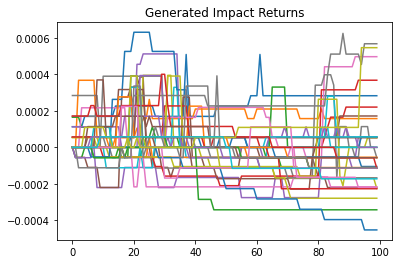

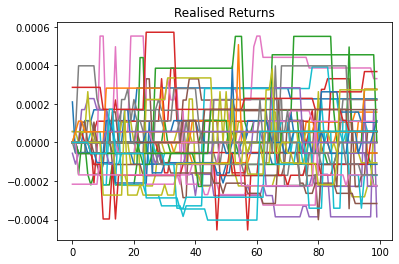

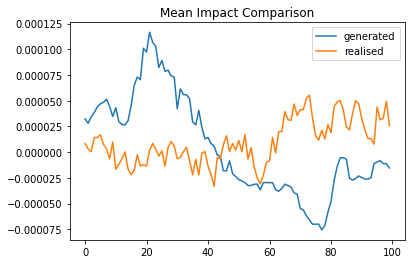

In [181]:
r_gen_df = pd.DataFrame(results['rets_gen'].T)
r_eval_df = pd.DataFrame(results['rets_eval'].T)

r_gen_df.plot()
plt.title('Generated Impact Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

r_eval_df.plot()
plt.title('Realised Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

plt.figure()
r_gen_df.mean(axis=1).plot(label='generated')
r_eval_df.mean(axis=1).plot(label='realised')
plt.legend()
plt.title('Mean Impact Comparison')

In [182]:
df_gen = r_gen_df.iloc[-1:].T
df_gen.columns = ['return']
df_gen['type'] = 'generated'
df_gen['n_gen_msgs'] = 100
df_gen['quantity'] = quantity

df_eval = r_eval_df.iloc[-1:].T
df_eval.columns = ['return']
df_eval['type'] = 'realised'
df_eval['n_gen_msgs'] = 100
df_eval['quantity'] = quantity

df_impact = pd.concat([df_gen, df_eval])
df_impact

,return,type,n_gen_msgs,quantity
0,0.000283,generated,100,100
1,0.000158,generated,100,100
2,-0.000112,generated,100,100
3,0.000221,generated,100,100
4,0.000055,generated,100,100
...,...,...,...,...
35,0.000171,realised,100,100
36,-0.000225,realised,100,100
37,-0.000168,realised,100,100
38,0.000273,realised,100,100


<Axes: xlabel='n_gen_msgs', ylabel='return'>

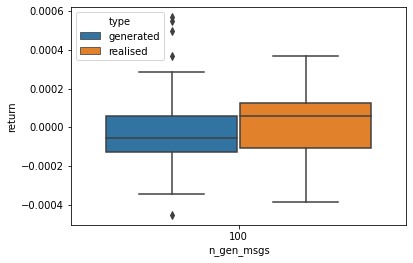

In [183]:
import seaborn as sns

sns.boxplot(x='n_gen_msgs', y='return', hue='type', data=df_impact)

### Inference evaluation

In [22]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

[[0.35251    0.5249197  0.09158999]
 [0.3723705  0.5504002  0.10856   ]]


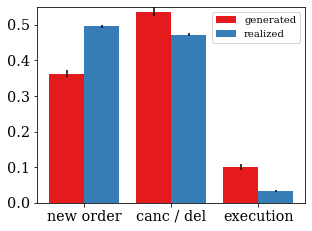

In [29]:
rng, rng_ = jax.random.split(rng)

eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    rng_,
    combine_mod = True
)
# set y axis limit
plt.ylim(0, 0.55)
plt.savefig(f'../figures/event_types_{stock}.png', dpi=300)

In [59]:
min_x = min(results['delta_t_gen'].min(), results['delta_t_eval'].min())
max_x = max(results['delta_t_gen'].max(), results['delta_t_eval'].max())
min_x, max_x
# GOOG: (Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))
# INTC: 

(Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))

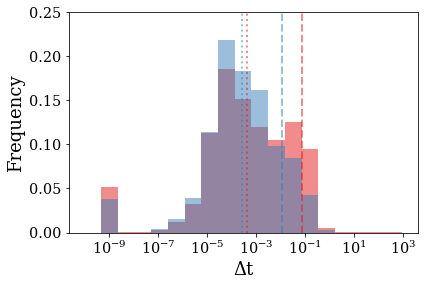

In [61]:
_ = eval.plot_log_hist(results['delta_t_gen'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
_ = eval.plot_log_hist(results['delta_t_eval'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
# set y axis limit
plt.ylim(0, 0.25)
plt.savefig(f'../figures/time_hist_{stock}.png', dpi=300)

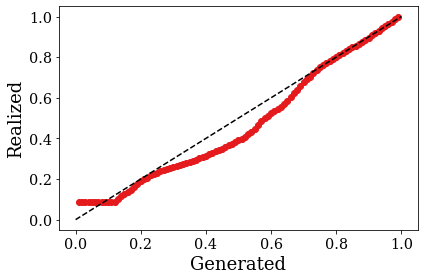

In [284]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)
plt.savefig(f'../figures/time_prob_{stock}.png', dpi=300)

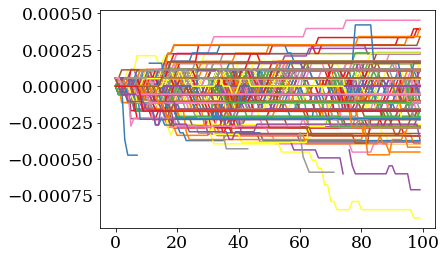

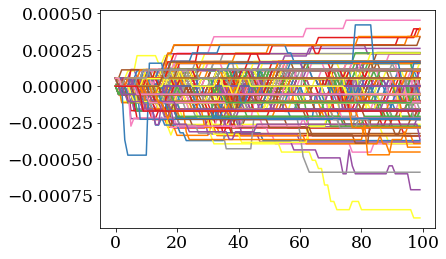

In [51]:
# remove NaNs (temporary empty book side) by forward filling returns

r_gen_df = pd.DataFrame(results['rets_gen'].T)

r_gen_df.plot()
# remove legend from current axis
plt.gca().get_legend().remove()

r_gen_df = r_gen_df.fillna(method='ffill')
r_gen_df.plot()
plt.gca().get_legend().remove()

r_gen = jnp.array(r_gen_df.values).T
r_eval = pd.DataFrame(results['rets_eval'].T).fillna(method='ffill')
r_eval = jnp.array(r_eval.values).T

# remove series starting with NaNs (one empty book side)
r_gen = r_gen[~jnp.isnan(r_eval[:, 0])]  # ... where eval is NaN!
r_eval = r_eval[~jnp.isnan(r_eval[:, 0])]

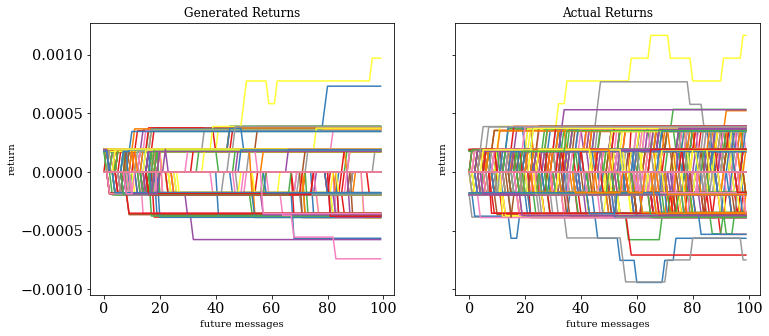

In [286]:
eval.plot_returns(r_gen, r_eval)

In [287]:
results['rets_gen'].shape

(989, 100)

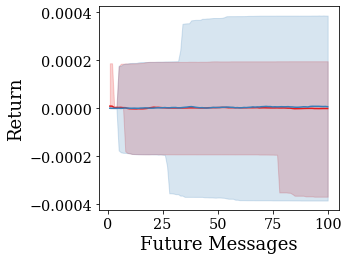

In [288]:
eval.plot_mean_returns(r_gen.T, r_eval.T)
plt.savefig(f'../figures/ret_dist_{stock}.png', dpi=300)

In [73]:
se, percentiles = eval.calc_moments_se(results['rets_gen'], rng)

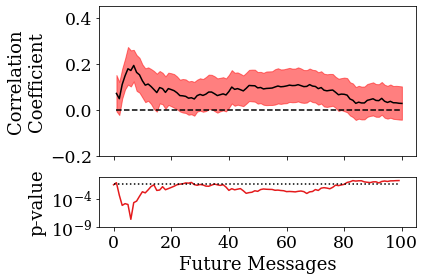

In [52]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(
    r_gen,
    r_eval,
    ci=0.95,
    ylims=((-0.2, 0.45), (1e-9, 1)),
    rng=rng_
)
plt.savefig(f'../figures/corr_{stock}.png', dpi=300)

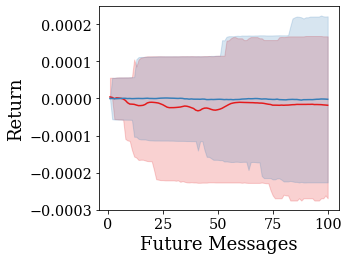

In [240]:
eval.plot_mean_returns(r_gen.T, r_eval.T)

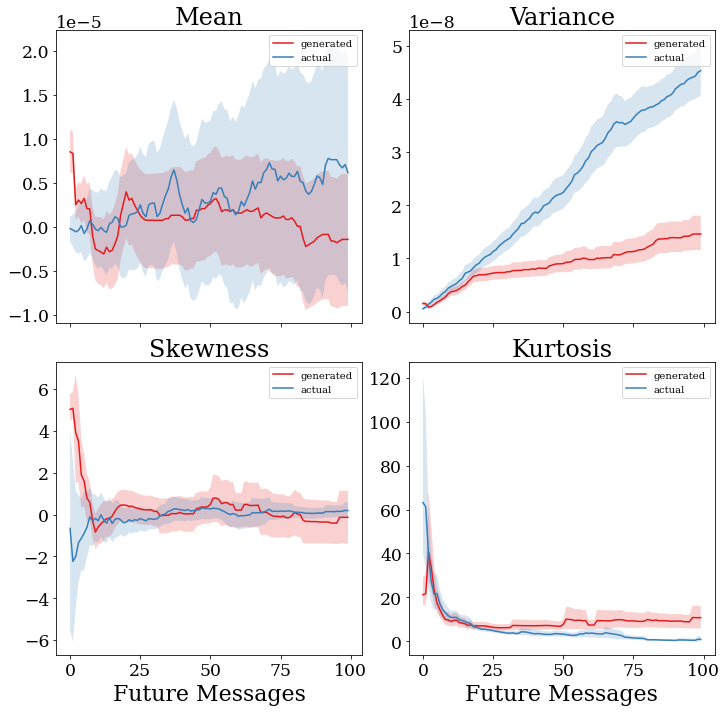

In [290]:
eval.plot_moments(r_gen, r_eval, ci=0.95, rng=rng_)
plt.savefig(f'../figures/moments_{stock}.png', dpi=300)

### DEBUG

In [52]:
ORDER_ID_i = 0
EVENT_TYPE_i = 1
DIRECTION_i = 2
PRICE_ABS_i = 3
PRICE_i = 4
SIZE_i = 5
DTs_i = 6
DTns_i = 7
TIMEs_i = 8
TIMEns_i = 9
PRICE_REF_i = 10
SIZE_REF_i = 11
TIMEs_REF_i = 12
TIMEns_REF_i = 13

In [81]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [82]:
i = 27742
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

sim_init, _trades = inference.get_sim(
    init_l2_book=book_l2_init,
    replay_msgs_raw=msg_seq_raw[: n_messages],
    sim_book_levels=sim_book_levels,
    sim_queue_len=sim_queue_len,
)

In [83]:
n_levels = 20
bids = sim_init.bids
asks = sim_init.asks


# MAX_INT = 2_147_483_647  # max 32 bit int

# # unique sorts ascending --> negative values to get descending
# bid_prices = -1 * jnp.unique(-1 * bids[:, 0], size=n_levels, fill_value=-1)
# # replace -1 with max 32 bit int in sorting asks before sorting
# ask_prices = jnp.unique(
#     jnp.where(asks[:, 0] == -1, MAX_INT, asks[:, 0]),
#     size=n_levels,
#     fill_value=-1
# )
# # replace max 32 bit int with -1 after sorting
# ask_prices = jnp.where(ask_prices == MAX_INT, -1, ask_prices)

# bids = jnp.stack((bid_prices, job.get_totquant_at_prices(bids, bid_prices)))
# asks = jnp.stack((ask_prices, job.get_totquant_at_prices(asks, ask_prices)))
# bids.T, asks.T

In [84]:
job.get_L2_state(asks, bids, n_levels)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [85]:
sim_init.asks.shape

(2000, 6)

In [86]:
job.get_next_executable_order(0, sim_init.asks)

Array([891400,    878,  -9000,      0,  34200,      0], dtype=int32)

In [87]:
sim_init.asks

Array([[   891400,       100, 347756706,         0,     40731, 836124038],
       [   890900,        90, 347772098,         0,     40732, 278549158],
       [   891400,       100, 347812694,         0,     40733, 362540625],
       ...,
       [       -1,        -1,        -1,        -1,        -1,        -1],
       [       -1,        -1,        -1,        -1,        -1,        -1],
       [       -1,        -1,        -1,        -1,        -1,        -1]],      dtype=int32)

In [88]:
job.get_order_by_id(sim_init.asks, 347812694)

Array([   891400,       100, 347812694,         0,     40733, 362540625],      dtype=int32)

In [89]:
sim_init.get_L2_state(n_levels)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [90]:
job.get_L2_state(sim_init.asks, sim_init.bids, 20)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [91]:
sim_init.get_L2_state(20)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [92]:
a_before = sim_init.asks, sim_init.bids

l2_before = sim_init.get_L2_state(n_levels)
l2_before

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [104]:
side = 1
quantity = 999
rel_price = 100 # make executable

encoder = v.ENCODING

In [105]:
m_seq_raw_inp = msg_seq_raw[: n_messages]

p_mid_old = sim_init.get_L2_state(n_levels)[([0, 2],)].mean().astype(jnp.int32)

event_type = 1  # new limit order
tick_size = 100
new_order_id = 42
time_init_s = m_seq_raw_inp[-1, DTs_i]
time_init_ns = m_seq_raw_inp[-1, DTns_i]
# assume impact message has same timestamp as last message in input sequence
delta_t_s, delta_t_ns = 0, 0
time_s, time_ns = time_init_s, time_init_ns
print('p_mid_old', p_mid_old)
# construct raw impact message
sim_msg, impact_msg, msg_raw = inference.get_sim_msg_new(
    p_mid_old,
    event_type, quantity, side, rel_price, delta_t_s, delta_t_ns, time_s, time_ns,
    new_order_id,
    tick_size,
    encoder,
)

p_mid_old 890500


In [95]:
sim_msg

Array([     1,      1,    999, 900500,      0,     42,      0, 294621],      dtype=int32)

In [96]:
impact_msg

Array([ 1003, 12010, 12008, 11107,  2006,     3,     3,     3,     3,
           3,     3,     3,   297,   624,     2,     2,     2,     2,
           2,     2,     2,     2], dtype=int32)

In [97]:
msg_raw

Array([    42,      1,      1, 900500,    100,    999,      0,      0,
            0, 294621,  -9999,  -9999,  -9999,  -9999], dtype=int32)

In [98]:
_trades = sim_init.process_order_array(sim_msg)
_trades

Array([[   890500,       100,     -9000, 347710702,     40731, 755919404],
       [   890500,       100,     -9000, 347694094,     40731, 756301878],
       [   890500,        74,     -9000, 347693014,     40731, 767385236],
       [   890500,       100,     -9000, 347690994,     40731, 769653831],
       [   890500,       100,     -9000, 347710590,     40731, 836067719],
       [   890600,       100,     -9000, 347728130,     40732, 127822930],
       [   890600,        22,     -9000, 347693310,     40732, 134103260],
       [   890600,        90,     -9000, 347666878,     40732, 275403772],
       [   890900,        10, 347666878, 347772098,     40732, 278549158],
       [   890500,         4, 347772418, 347764602,     40732, 289031697],
       [   891100,        18, 347764602, 347772526,     40732, 289031697],
       [   890500,        38, 347772422, 347735590,     40732, 289076410],
       [   890500,         1, 347772422, 347721438,     40732, 290936618],
       [   890500,       

In [99]:
_trades.shape

(100, 6)

In [103]:
l2_before

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [102]:
sim_init.get_L2_state(n_levels)

Array([890700,    100, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,    294, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [ ]:
sim_init.orderbook_array.shape

(2, 20, 100, 6)

In [64]:
m_seq_raw_inp[:31]

Array([[347721814,         3,         1,    889900,        -5,       100,
                0,   5313344,     40731, 633486247,        -5,       100,
            40731, 132656455],
       [347743798,         1,         1,    889800,        -6,       100,
                0,    221053,     40731, 633707300,     -9999,     -9999,
            -9999,     -9999],
       [347743854,         1,         1,    890300,        -1,       100,
                0,   1899085,     40731, 635606385,     -9999,     -9999,
            -9999,     -9999],
       [347743854,         3,         1,    890300,        -1,       100,
                0,  31171769,     40731, 666778154,        -1,       100,
            40731, 635606385],
       [347746026,         1,         1,    890300,        -1,       100,
                0,  15970362,     40731, 682748516,     -9999,     -9999,
            -9999,     -9999],
       [347746026,         3,         1,    890300,        -1,       100,
                0,     48433,  

In [111]:
# DEBUG: sim replay

i = 27742

m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[i]
m_seq_raw_inp = msg_seq_raw[: n_messages]
m_seq_raw_eval = msg_seq_raw[n_messages: ]

sim = OrderBook()
# init simulator at the start of the sequence
inference.reset_orderbook(sim, book_l2_init)
# replay sequence in simulator (actual)
# so that sim is at the same state as the model

print('init L2 state')
print(sim.get_L2_state(n_levels))
print('init book data')
print(b_seq_pv[0, 1:21])

for i in range(m_seq_raw_inp.shape[0] - 1):
    print(i)
    replay = inference.msgs_to_jnp(m_seq_raw_inp[i: i+1])
    print(replay)
    trades = sim.process_orders_array(replay)
    best_bid, best_ask = sim.get_best_bid(), sim.get_best_ask()
    print(
        encoding.repr_raw_msg(m_seq_raw_inp[i])
    )
    print('trades:\n', trades)
    print(best_bid, best_ask)
    print(sim.get_L2_state(n_levels))
    if best_bid >= best_ask:
        print("ERROR: CROSSED PRICES")
    print('book data')
    print(b_seq_pv[i+1, 1:21])
        
    print()

    if i == 29:
    # if i == 30:
        break

print(sim.asks)
print(sim.bids)

init L2 state
[890500    474 890300    188 890600    212 890200    542 890700    508
 890100    350 890800    974 890000    906 890900    459 889900    650
 891000   1175 889800   1473 891100   1134 889700   1018 891200    845
 889600    556 891300    580 889500    599 891400    878 889400    150
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
init book data
[890500    474 890300    188 890600    212 890200    542 890700    508
 890100    350 890800    974 890000    906 890900    459 889900    650]
0
[[        3         1       100    889900         0 347721814     40731
  633486247]]
OID:	347721814
event_type:	3
direction:	1
price_abs:	889900
price:	-5
size:	100
delta_t_s:	0
delta_t_ns:	5313344
time_s:	40731
time_ns:	633486247
p_ref:	-5
size_ref:	100
t

In [118]:
sim.get_volume_at_price(1, 890300)

Array(0, dtype=int32)